In [ ]:
zip_path = '/content/drive/My\ Drive/Deep_Learning/birth.zip'
!cp {zip_path} /content/
!cd /content/
!unzip -q /content/birth.zip -d /content
!rm /content/birth.zip

In [ ]:
# From: https://machinelearningmastery.com/exploratory-configuration-multilayer-perceptron-network-time-series-forecasting/
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np

In [ ]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

# Data Loading

In [ ]:
dataset = pd.read_csv('/content/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataset.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

## Plot Dataset

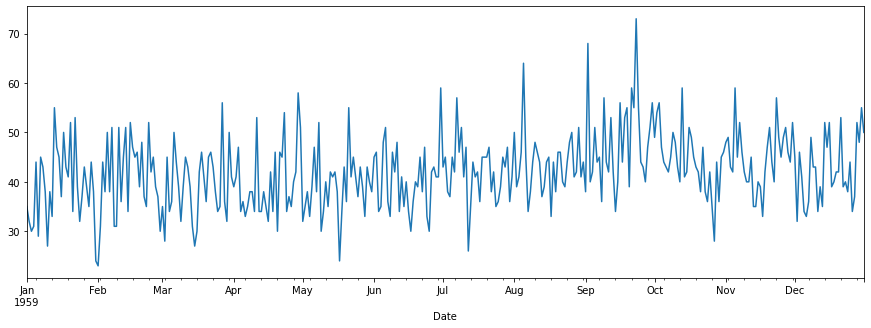

In [ ]:
dataset.plot(figsize=(15,5))
plt.show()

## Processing Time-series Data

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -3
1      -2
2       1
3      13
4     -15
       ..
359     3
360    15
361    -4
362     7
363    -5
Length: 364, dtype: int64

In [ ]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-3
1,-3.0,-2
2,-2.0,1
3,1.0,13
4,13.0,-15
...,...,...
359,-10.0,3
360,3.0,15
361,15.0,-4
362,-4.0,7


In [ ]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[ -3.,  -2.],
       [ -2.,   1.],
       [  1.,  13.],
       [ 13., -15.],
       [-15.,  16.],
       [ 16.,  -2.],
       [ -2.,  -5.],
       [ -5., -11.],
       [-11.,  11.],
       [ 11.,  -5.],
       [ -5.,  22.],
       [ 22.,  -8.],
       [ -8.,  -2.],
       [ -2.,  -8.],
       [ -8.,  13.],
       [ 13.,  -7.],
       [ -7.,  -2.],
       [ -2.,  11.],
       [ 11., -18.],
       [-18.,  19.],
       [ 19., -14.],
       [-14.,  -7.],
       [ -7.,   5.],
       [  5.,   6.],
       [  6.,  -4.],
       [ -4.,  -4.],
       [ -4.,   9.],
       [  9.,  -6.],
       [ -6., -14.],
       [-14.,  -1.],
       [ -1.,   8.],
       [  8.,  13.],
       [ 13.,  -6.],
       [ -6.,  12.],
       [ 12., -12.],
       [-12.,  13.],
       [ 13., -20.],
       [-20.,   0.],
       [  0.,  20.],
       [ 20., -15.],
       [-15.,   9.],
       [  9.,   6.],
       [  6., -17.],
       [-17.,  18.],
       [ 18.,  -5.],
       [ -5.,  -2.],
       [ -2.,   1.],
       [  1.,

In [ ]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
train_scaled

array([[-1.37931034e-01, -1.03448276e-01],
       [-1.03448276e-01, -6.93889390e-17],
       [-6.93889390e-17,  4.13793103e-01],
       [ 4.13793103e-01, -5.51724138e-01],
       [-5.51724138e-01,  5.17241379e-01],
       [ 5.17241379e-01, -1.03448276e-01],
       [-1.03448276e-01, -2.06896552e-01],
       [-2.06896552e-01, -4.13793103e-01],
       [-4.13793103e-01,  3.44827586e-01],
       [ 3.44827586e-01, -2.06896552e-01],
       [-2.06896552e-01,  7.24137931e-01],
       [ 7.24137931e-01, -3.10344828e-01],
       [-3.10344828e-01, -1.03448276e-01],
       [-1.03448276e-01, -3.10344828e-01],
       [-3.10344828e-01,  4.13793103e-01],
       [ 4.13793103e-01, -2.75862069e-01],
       [-2.75862069e-01, -1.03448276e-01],
       [-1.03448276e-01,  3.44827586e-01],
       [ 3.44827586e-01, -6.55172414e-01],
       [-6.55172414e-01,  6.20689655e-01],
       [ 6.20689655e-01, -5.17241379e-01],
       [-5.17241379e-01, -2.75862069e-01],
       [-2.75862069e-01,  1.37931034e-01],
       [ 1.

# Baseline Model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0894 - val_loss: 0.0574
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0872 - val_loss: 0.0563
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0856 - val_loss: 0.0554
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0549
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0837 - val_loss: 0.0546
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0829 - val_loss: 0.0545
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0544
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0544
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.0544
Epoch 10/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0820 - val_loss: 0.0545
Epoch 11/1000
9/9 

In [ ]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

3/3 - 0s - loss: 0.0547
Test loss: 0.05467664450407028


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

In [ ]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
6,0.082620,0.054383,6
7,0.082255,0.054387,7
8,0.082144,0.054435,8
628,0.080520,0.054438,628
130,0.080546,0.054444,130
...,...,...,...
3,0.084478,0.054911,3
690,0.080521,0.054938,690
2,0.085609,0.055444,2
1,0.087159,0.056256,1


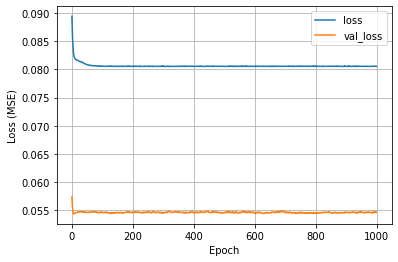

In [ ]:
plot_loss(history) # epoch vs loss graph

# Deeper Model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0993 - val_loss: 0.0619
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0977 - val_loss: 0.0610
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0965 - val_loss: 0.0602
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0954 - val_loss: 0.0595
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0942 - val_loss: 0.0590
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0933 - val_loss: 0.0585
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0924 - val_loss: 0.0580
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0916 - val_loss: 0.0576
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0908 - val_loss: 0.0571
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0902 - val_loss: 0.0568
Epoch 11/1000
9/9 

In [ ]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
28,0.082218,0.053610,28
27,0.082472,0.053613,27
31,0.081795,0.053623,31
29,0.082055,0.053641,29
32,0.081627,0.053649,32
...,...,...,...
4,0.094240,0.059003,4
3,0.095366,0.059519,3
2,0.096492,0.060209,2
1,0.097732,0.061020,1


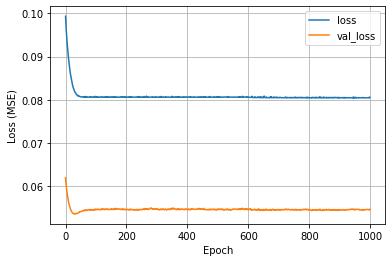

In [ ]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider Model

In [ ]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.0965 - val_loss: 0.0603
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0910 - val_loss: 0.0578
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0887 - val_loss: 0.0564
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0863 - val_loss: 0.0559
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0850 - val_loss: 0.0554
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0843 - val_loss: 0.0551
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0549
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.0548
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0548
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0547
Epoch 11/1000
9/9 

In [ ]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
78,0.080671,0.054046,78
64,0.080649,0.054047,64
26,0.080822,0.054084,26
14,0.081437,0.054122,14
65,0.080643,0.054149,65
...,...,...,...
3,0.086323,0.055882,3
452,0.081066,0.055935,452
2,0.088702,0.056365,2
1,0.090996,0.057827,1


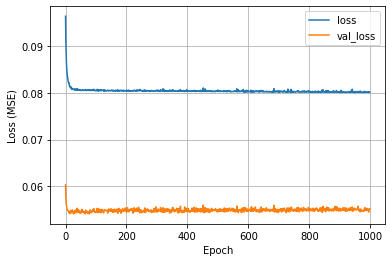

In [ ]:
plot_loss(wider_model_history)

# LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0659 - val_loss: 0.0556
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0542
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 4/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0541
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0539
Epoch 6/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0540
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0541

In [ ]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
440,0.057818,0.053747,440
347,0.057802,0.053749,347
806,0.057592,0.053750,806
445,0.057763,0.053754,445
326,0.057817,0.053755,326
...,...,...,...
281,0.057902,0.054288,281
977,0.057511,0.054298,977
196,0.058023,0.054318,196
72,0.058116,0.054324,72


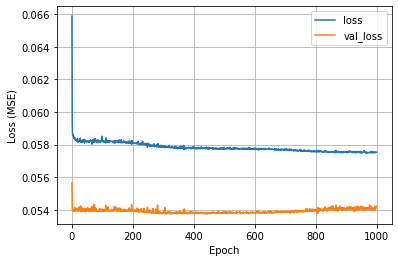

In [ ]:
plot_loss(lstm_model_history)

# Kesimpulan
Arsitektur terbaik untuk dataset birth adalah deeper model, dengan nilai val_loss 0.0536 pada epoch ke-28.